In [10]:
import time
from functools import partial
from pprint import pprint
from typing import Literal

from audiostream2py.file import WavFileSourceReader
from audiostream2py.data import AudioSegment
from meshed.slabs import Slabs
import numpy as np



In [11]:
from pyckup import grab


plc_url = 'https://www.dropbox.com/s/pwjw0o5ox91nvi2/PLC.wav?dl=0'
wf_url = 'https://www.dropbox.com/s/lxo226rft2h94nf/wf.wav?dl=0'

#wf = graze(wf_url)
plc_bytes = grab(plc_url)
wf_bytes = grab(wf_url)

In [12]:
#plc_file = PLUNK_ROOT_PATH / 'sb/slabsiter_experiments/data/PLC.wav'
#accel_file = PLUNK_ROOT_PATH / 'sb/slabsiter_experiments/data/1621346260226336_ch2.wav'

#plc_file = 'data/PLC.wav'
#accel_file = 'data/1621346260226336_ch2.wav'

plc_file = plc_bytes
accel_file = wf_bytes

#assert plc_file.is_file(), f'File not found: {plc_file}'
#assert accel_file.is_file(), f'File not found: {accel_file}'

plc_source = WavFileSourceReader(plc_file, frames_per_buffer=5, start_date=0)
accel_source = WavFileSourceReader(accel_file, frames_per_buffer=12800, start_date=0)

print('plc info:')
pprint(plc_source.info)
print('accel info:')
pprint(accel_source.info)

plc info:
{'bt': 0,
 'channels': 1,
 'frames_per_buffer': 5,
 'n_frames': 59650,
 'rate': 50,
 'width': 2}
accel info:
{'bt': 0,
 'channels': 1,
 'frames_per_buffer': 12800,
 'n_frames': 15270400,
 'rate': 12800,
 'width': 2}


In [13]:
# Charlie's code
class BoolSegmentEdgeDetector:
    last_sample_of_previous_segment = None
    
    def detect_edge_indices(
        self, bool_segment: np.ndarray, edge_type: Literal['rising', 'falling', 'both']
    ) -> list:
        if edge_type not in ['rising', 'falling', 'both']:
            raise ValueError(
                "Valid values for edge_type parameter are 'rising', 'falling', and 'both'."
            )
        if self.last_sample_of_previous_segment is not None:
            bool_segment = np.insert(bool_segment, 0, self.last_sample_of_previous_segment)
        self.last_sample_of_previous_segment = bool_segment[-1]

        int_segment = bool_segment.astype(int)
        edges = np.diff(int_segment)
        if edge_type == 'rising':
            return np.nonzero(edges == 1)[0].tolist()
        elif edge_type == 'falling':
            return np.nonzero(edges == -1)[0].tolist()
        else:
            return np.nonzero(edges)[0].tolist()


# class AudioSegmentBuffer:
#     write_state = False
#     buffered_segment = AudioSegment.empty()

#     def read_values(self, ts):
#         if not self.write_state:
#             self.write_state = True
#             return None
#         values = self.buffered_segment[:ts]
#         self.buffered_segment = self.buffered_segment[ts:]
#         return values

#     def write_values(self, incoming_segment: AudioSegment):
#         if self.write_state:
#             self.buffered_segment += incoming_segment

In [14]:
from typing import Union, Tuple, List

def get_bytes_of_audio_segment(audio_segment: AudioSegment) -> bytes:
    return audio_segment.waveform

def convert_bytes_to_array(bytes_: bytes, dtype: type) -> np.ndarray:
    return np.frombuffer(bytes_, dtype=dtype)

def convert_array_to_bool(array: np.ndarray) -> np.ndarray:
    return array != 0  

def instantiate_rising_edge_detector() -> callable:
    return partial(BoolSegmentEdgeDetector().detect_edge_indices(edge_type='rising'))

def get_index_of_event(event_detector: callable, data_segment: np.ndarray) -> list[int]:
    return event_detector(data_segment)

# Should we use generators starting from here? How to separate that concern??

def get_audio_ts_from_index(audio_segment: AudioSegment, index: int) -> tuple:
    return audio_segment.get_ts_of_frame_index(index)

def get_ts_of_index(audio_segment, ind: int) -> Tuple[Union[int, float]]:
        if not 0 <= ind < len(audio_segment.waveform):
            raise IndexError(f'The index must be between 0 and {len(audio_segment.waveform)-1}.')
        bt = audio_segment.bt + ind/len(audio_segment.waveform) * (audio_segment.tt-audio_segment.bt)
        tt = audio_segment.bt + (ind+1)/len(audio_segment.waveform) * (audio_segment.tt-audio_segment.bt)
        return (bt, tt)

def get_bt_of_ts(ts: tuple):
    return ts[0]

def instanciate_audio_segment_buffer():
    return AudioSegmentBuffer()

def write_to_buffer(buffer, audio_segment: AudioSegment) -> None:
    buffer.write_values(audio_segment)

def read_buffer(buffer, ts) -> AudioSegment:
    return buffer.read_values(ts)

def convert_bytes_to_floats(bytes_: bytes):
    pass
    # Use recode here
    # wf = np.array(decode_pcm_bytes(wf_bytes)

def first_featurizer(audio_segments: list[AudioSegment]) -> list[float]:
    pass

In [15]:
from creek import BufferStats
from collections import deque
from recode import decode_pcm_bytes


def identity(x):
    return x
bs = BufferStats(values = (-1,-1),maxlen=2, func=identity)

In [16]:
# SLABS
counter = 0
with accel_source.stream_buffer(maxlen=None) as accel_buffer:
    accel_reader = accel_buffer.mk_reader()
    
    with plc_source.stream_buffer(maxlen=None) as plc_buffer:
        plc_reader = plc_buffer.mk_reader()
        time.sleep(.1)
        next_plc = partial(plc_reader.next, ignore_no_item_found=True)

        slabs = Slabs(
            wf_buffer = lambda: accel_reader,
            plc_segment = next_plc,
            last_plc = lambda plc_segment: plc_segment.waveform[-1] ,
            view_segment = lambda plc_segment: plc_segment.waveform,
            int_segment = lambda plc_segment: np.array(decode_pcm_bytes(plc_segment.waveform)),
            bool_segment = lambda int_segment: (int_segment != 0).astype(int),
            buffered_last = lambda bool_segment: bs(bool_segment[-1]), #(previous_last, current_last),

            edges = lambda bool_segment, buffered_last: np.diff(bool_segment, prepend=buffered_last[0]),
            edges_rising_idx = lambda edges: [i for i, x in enumerate(edges) if x == 1],
            edges_falling_idx = lambda edges: [i for i, x in enumerate(edges) if x == -1],

            ts_for_rising_edge = lambda edges_rising_idx, plc_segment: [('rising',get_ts_of_index(plc_segment, i)) for i in edges_rising_idx],
            ts_for_falling_edge = lambda edges_falling_idx, plc_segment: [('falling',get_ts_of_index(plc_segment, i)) for i in edges_falling_idx],
            begin_ts = lambda plc_segment: get_ts_of_index(plc_segment, 0),
            end_ts = lambda plc_segment: get_ts_of_index(plc_segment, len(plc_segment.waveform)-1),
            
            #rising_edges_count_mod_2 = lambda edges: sum(x % 2 for x in edges if x==1),
            #bool_plot = lambda bool_segment: simple_plot(bool_segment),

            #sink = lambda last_plc: print(last_plc)
        )

        for s in slabs:
            counter +=1
            print(f'segment={s.get("bool_segment")} edges={s.get("edges")} edges_ones_idx={s.get("edges_rising_idx")} ts_for_rising_edge={s.get("ts_for_rising_edge")} ts_for_falling_edge={s.get("ts_for_falling_edge")}')

            if counter>15:
                break
            #if fvs is not None,:
            #    print(f'{s.get('fvs')}')
            # if (fvs := s.get('fvs')) is not None: 
            #     print(fvs)



segment=[0 0 0 0 0] edges=[1 0 0 0 0] edges_ones_idx=[0] ts_for_rising_edge=[('rising', (0.0, 10000.0))] ts_for_falling_edge=[]
segment=[0 0 0 0 0] edges=[0 0 0 0 0] edges_ones_idx=[] ts_for_rising_edge=[] ts_for_falling_edge=[]
segment=[0 0 0 0 0] edges=[0 0 0 0 0] edges_ones_idx=[] ts_for_rising_edge=[] ts_for_falling_edge=[]
segment=[0 0 0 0 0] edges=[0 0 0 0 0] edges_ones_idx=[] ts_for_rising_edge=[] ts_for_falling_edge=[]
segment=[0 0 0 0 0] edges=[0 0 0 0 0] edges_ones_idx=[] ts_for_rising_edge=[] ts_for_falling_edge=[]
segment=[0 0 0 0 0] edges=[0 0 0 0 0] edges_ones_idx=[] ts_for_rising_edge=[] ts_for_falling_edge=[]
segment=[0 0 0 0 0] edges=[0 0 0 0 0] edges_ones_idx=[] ts_for_rising_edge=[] ts_for_falling_edge=[]
segment=[0 0 0 0 0] edges=[0 0 0 0 0] edges_ones_idx=[] ts_for_rising_edge=[] ts_for_falling_edge=[]
segment=[0 0 0 0 0] edges=[0 0 0 0 0] edges_ones_idx=[] ts_for_rising_edge=[] ts_for_falling_edge=[]
segment=[0 0 0 0 0] edges=[0 0 0 0 0] edges_ones_idx=[] ts_for_r

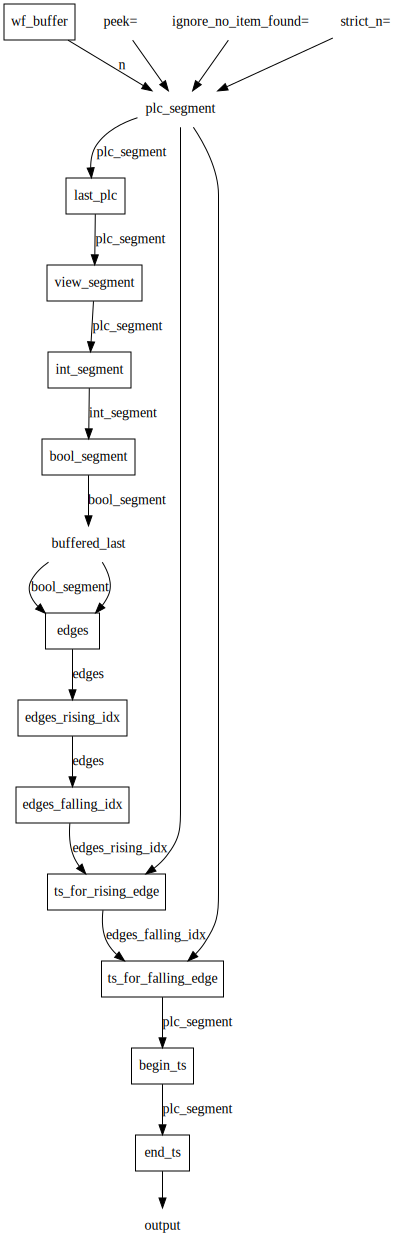

In [17]:
slabs.dot_digraph()


# Simplified slabs

In [ ]:
def to_bool_segment(plc_segment):
    int_segment = np.array(decode_pcm_bytes(plc_segment.waveform))
    bool_segment =  (int_segment != 0).astype(int)
    return bool_segment

In [1]:
# SLABS
counter = 0
with accel_source.stream_buffer(maxlen=None) as accel_buffer:
    accel_reader = accel_buffer.mk_reader()
    
    with plc_source.stream_buffer(maxlen=None) as plc_buffer:
        plc_reader = plc_buffer.mk_reader()
        time.sleep(.1)
        next_plc = partial(plc_reader.next, ignore_no_item_found=True)

        slabs = Slabs(
            wf_buffer = lambda: accel_reader,
            plc_segment = next_plc,
            last_plc = lambda plc_segment: plc_segment.waveform[-1] ,
            #view_segment = lambda plc_segment: plc_segment.waveform,
            int_segment = lambda plc_segment: np.array(decode_pcm_bytes(plc_segment.waveform)),
            bool_segment = lambda int_segment: (int_segment != 0).astype(int),
            buffered_last = lambda bool_segment: bs(bool_segment[-1]), #(previous_last, current_last),

            edges = lambda bool_segment, buffered_last: np.diff(bool_segment, prepend=buffered_last[0]),
            edges_rising_idx = lambda edges: [i for i, x in enumerate(edges) if x == 1],
            edges_falling_idx = lambda edges: [i for i, x in enumerate(edges) if x == -1],

            ts_for_rising_edge = lambda edges_rising_idx, plc_segment: [('rising',get_ts_of_index(plc_segment, i)) for i in edges_rising_idx],
            ts_for_falling_edge = lambda edges_falling_idx, plc_segment: [('falling',get_ts_of_index(plc_segment, i)) for i in edges_falling_idx],
            begin_ts = lambda plc_segment: get_ts_of_index(plc_segment, 0),
            end_ts = lambda plc_segment: get_ts_of_index(plc_segment, len(plc_segment.waveform)-1),
            
            #rising_edges_count_mod_2 = lambda edges: sum(x % 2 for x in edges if x==1),
            #bool_plot = lambda bool_segment: simple_plot(bool_segment),

            #sink = lambda last_plc: print(last_plc)
        )

        for s in slabs:
            counter +=1
            print(f'segment={s.get("bool_segment")} edges={s.get("edges")} edges_ones_idx={s.get("edges_rising_idx")}')
            if counter>15:
                break
            #if fvs is not None,:
            #    print(f'{s.get('fvs')}')
            # if (fvs := s.get('fvs')) is not None: 
            #     print(fvs)

NameError: name 'accel_source' is not defined

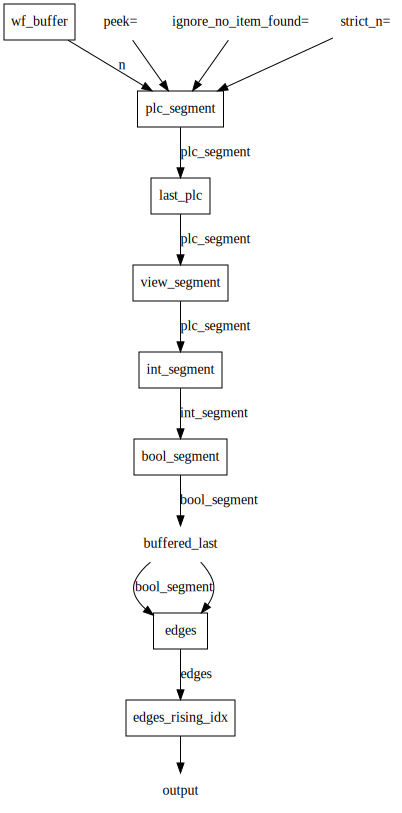

In [19]:
slabs.dot_digraph()

In [ ]:
def intervals_sequence(ts_for_rising_edge, ts_for_falling_edge):
    pass

def add_to_buffer(ts_for_rising_edge, ts_for_falling_edge, begin_ts, end_ts):
    pass

In [ ]:
ts_for_rising_edge = [('rising', (0, 0.0001)), ('rising', (0.0004, 0.0005)), ('rising', (0.0007, 0.0008))]
ts_for_falling_edge = [('falling', (0.0003, 0.0004)), ('falling', (0.0006, 0.0007)), ('falling', (0.0009, 0.0010))]

def order_ts_for_edge(ts_for_rising_edge, ts_for_falling_edge):
    ts_for_edge = ts_for_rising_edge + ts_for_falling_edge
    return sorted(ts_for_edge, key=lambda x: x[1][0])

def added_to_buffer(ts_for_rising_edge, ts_for_falling_edge, begin_ts, end_ts, write_state):
    if (not ts_for_rising_edge and not ts_for_falling_edge) and write_state:
        return [(begin_ts, end_ts)]
    ts_for_edge = order_ts_for_edge(ts_for_rising_edge, ts_for_falling_edge)
    if ts_for_edge and ts_for_edge[0][0] == 'falling':
        return [(begin_ts, ts_for_edge[0][1][1])]
    return None

def update_buffer(buffer, new_buffer):
    if buffer:
        return buffer + new_buffer
    else:
        return buffer 

def release_buffer(ts_for_edge):
    return ts_for_edge and ts_for_edge[0][0] == 'falling'

def release_buffer():
    pass

order_ts_for_edge(ts_for_rising_edge, ts_for_falling_edge)

In [ ]:
BufferStats??

In [ ]:
class accumulate:
    def __init__(self, func, start_value, **kwargs):
        self.func = func
        self.kwargs = kwargs
        self.start_value = start_value
        self.state = start_value

    def __call__(self, x):
        self.state = self.func(self.state, x, **self.kwargs)
        return self.state

In [ ]:
def adder(x,y):
    return x + y

In [ ]:
arr = [1,2,3,4,5]

In [ ]:
acc = accumulate(adder, 0)

In [ ]:
list(map(acc, arr))

# Session with Thor 05/06/2023

1
None
None
3
None
None
1
None
None
3
None
None
1
None
None
3
None
None
1
None
None
3
None
None
1
None
None
3
None
None


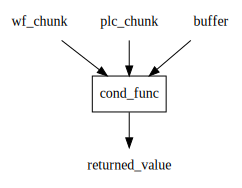

In [22]:
from collections import deque
from itertools import chain, cycle
from slang import fixed_step_chunker
from meshed import code_to_dag

wf_chunks = fixed_step_chunker(range(100), chk_size=5)
plc_chunks = cycle(
    [{'a': 1, 'b': 2}, {'a': 2, 'b': 4}, {'a': 3, 'b': 6}, {'a': 4, 'b': 8}]
)


is_odd = lambda x: (x % 2) == 1


add_to_buffer = lambda wf_chunk, buffer: buffer.append(wf_chunk)

# release the whole buffer
def release_buffer(buffer):
    buffer_contents = list(chain.from_iterable(buffer))
    buffer.clear()
    return buffer_contents


buffer = deque(maxlen=50)

wf_chunk = next(iter(wf_chunks))
plc_chunk = next(iter(plc_chunks))

add_to_buffer([1,2,3], buffer)
add_to_buffer([10,20], buffer) 
assert list(buffer) == [[1, 2, 3], [10, 20]]
release_buffer(buffer) == [1, 2, 3, 10, 20]

def dag_func(wf_chunk, plc_chunk, buffer):
    """if is_odd(plc_chunk['a']) then add wf_chunk to buffer
    and if is_odd(plc_chunk['a']) == 4 then release the buffer"""
    # wf_chunk = next(iter(wf_chunks))
    # plc_chunk = next(iter(plc_chunks))
    if is_odd(plc_chunk['a']):
        add_to_buffer(wf_chunk, buffer)
        if plc_chunk['a'] == 4:
            return release_buffer(buffer)


from functools import partial
from meshed.util import if_then_else

def add_buffer_and_possibly_release(wf_chunk, plc_chunk, buffer):
    add_to_buffer(wf_chunk, buffer)
    print(plc_chunk['a'])
    if plc_chunk['a'] == 4:
        return release_buffer(buffer)


cond_func = partial(
    if_then_else,
    if_func=lambda wf_chunk, plc_chunk, buffer: is_odd(plc_chunk['a']),
    then_func=add_buffer_and_possibly_release,
    else_func=lambda wf_chunk, plc_chunk, buffer: None
)


@code_to_dag
def dag():
    returned_value = cond_func(wf_chunk, plc_chunk, buffer)


dag.dot_digraph()

In [24]:
from slang import fixed_step_chunker
from itertools import cycle
from functools import partial
from meshed.util import if_then_else

wf_chunks = fixed_step_chunker(range(100), chk_size=5)
plc_chunks = cycle(
    [{'a': 1, 'b': 2}, {'a': 2, 'b': 4}, {'a': 3, 'b': 6}, {'a': 4, 'b': 8}]
)

buffer = deque(maxlen=30)


cond_func = partial(
    if_then_else,
    lambda wf_chunk, plc_chunk, buffer: is_odd(plc_chunk['a']),
    add_buffer_and_possibly_release,
    lambda wf_chunk, plc_chunk, buffer: None
)

for wf_chunk, plc_chunk in zip(wf_chunks, plc_chunks):
    # print(plc_chunk)
    print(cond_func(wf_chunk, plc_chunk, buffer))


def return_none_if_any_input_none(func, *args, **kwargs):
    def func_wrapper(*args, **kwargs):
        if any(arg is None for arg in args) or any(kwarg is None for kwarg in kwargs.values()):
            return None
        else:
            return func(*args, **kwargs)
        
    return func_wrapper

1
None
None
3
None
None
1
None
None
3
None
None
1
None
None
3
None
None
1
None
None
3
None
None
1
None
None
3
None
None
